Random Forest + SHAP for interpretability

Hierarchical Clustering

compare models using cross-validation (r2, MAE, MSE) - bad results, too small of a dataset, fitting noise

test linear models

try - Gradient Boosted Trees (XGBoost, LightGBM)
- SVMs to compare with FRs

Hold-One-Back cross validation

build a model ?

you need 10 times as many observations as you have features

bayesian model - prior knowledge is prev research

Predicting face fixation proportions.

### Imports & combining files

In [286]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.cluster.hierarchy import linkage, fcluster
import shap
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score



In [287]:
# Load files
proportions_df = pd.read_csv('/Users/alina/Downloads/Thesis/raw/Proportions_all_recordings.csv')
full_side_face_df = pd.read_csv('/Users/alina/Downloads/Thesis/raw/Full_side_prop_all_recordings.csv')
face_features_transitions_df = pd.read_csv('/Users/alina/Downloads/Thesis/raw/participant_face_transition_probabilities.csv')
first_face_fixations_df = pd.read_csv('/Users/alina/Downloads/Thesis/raw/first_face_fixations.csv')
second_face_fixations_df = pd.read_csv('/Users/alina/Downloads/Thesis/raw/second_face_fixations.csv')
fixation_stats_df = pd.read_csv('/Users/alina/Downloads/Thesis/raw/Fixations_stats_all_recordings.csv')

# --- Merge proportions and face transitions ---
merged = pd.merge(proportions_df, full_side_face_df, on='Participant')
merged = pd.merge(merged, face_features_transitions_df, on='Participant')

# --- Aggregate fixation stats by participant (median across recordings) ---
fixation_stats_subset = fixation_stats_df.groupby('Participant')[[
    'face median duration (ms)', 
    'body median duration (ms)', 
    'background median duration (ms)'
]].median().reset_index()

# Merge aggregated fixation stats
merged = pd.merge(merged, fixation_stats_subset, on='Participant')

# --- First face fixation proportions ---
counts1 = first_face_fixations_df.groupby(['Participant', 'First_Face_AOI']).size().reset_index(name='count')
counts1['proportion'] = counts1['count'] / counts1.groupby('Participant')['count'].transform('sum')
pivot1 = counts1.pivot(index='Participant', columns='First_Face_AOI', values='proportion').fillna(0)
pivot1 = pivot1.rename(columns=lambda x: f"1st face-{x} fixations")
merged = merged.merge(pivot1, on='Participant', how='left')

# --- Second face fixation proportions ---
counts2 = second_face_fixations_df.groupby(['Participant', 'Second_Face_AOI']).size().reset_index(name='count')
counts2['proportion'] = counts2['count'] / counts2.groupby('Participant')['count'].transform('sum')
pivot2 = counts2.pivot(index='Participant', columns='Second_Face_AOI', values='proportion').fillna(0)
pivot2 = pivot2.rename(columns=lambda x: f"2nd face-{x} fixations")
merged = merged.merge(pivot2, on='Participant', how='left')

# --- Drop unnecessary columns ---
columns_to_drop = [
    'Participant',
    'face fixations',
    'body fixations',
    'background fixations',
    'Total fixations',
    'left_eye',
    'right_eye',
    'nose',
    'mouth',
    'matched_fixations',
    'side-faces fixations',
    'full-faces fixations'
]
all_variables_df = merged.drop(columns=columns_to_drop, errors='ignore')
#all_variables_df.info()

In [288]:
#old

merged_df = pd.merge(proportions_df, full_side_face_df, on='Participant')
clustering_df = pd.merge(merged_df, face_features_transitions_df, on='Participant')


In [289]:
# old
#  adding first face fixations proportions
# Calculate counts per Participant and AOI
counts = first_face_fixations_df.groupby(['Participant', 'First_Face_AOI']).size().reset_index(name='count')

# Calculate total fixations per participant
total_counts = counts.groupby('Participant')['count'].transform('sum')

# Calculate proportion per AOI
counts['proportion'] = counts['count'] / total_counts

# 4.  Rename columns to have prefix "1st face-"
proportion_pivot = counts.pivot(index='Participant', columns='First_Face_AOI', values='proportion').fillna(0)
proportion_pivot = proportion_pivot.rename(columns=lambda x: f"1st face-{x} fixations")

# Merge into clustering_df
clustering_df = clustering_df.merge(proportion_pivot, on='Participant', how='left')

columns_to_drop = [
    'Participant',
    'face fixations',
    'body fixations',
    'background fixations',
    'Total fixations',
    'left_eye',
    'right_eye',
    'nose',
    'mouth',
    'matched_fixations',
    'side-face fixations',
    'full-faces fixations'
]

clustering_df = clustering_df.drop(columns=columns_to_drop, errors='ignore')

## same with second_face_fixations_df

## Random Forest Regression

In [290]:
target = 'proportion face'

# All columns except the target column
predictors = [col for col in all_variables_df.columns if col != target]

X = all_variables_df[predictors]
y = all_variables_df[target]

In [291]:
## to leave only "important features"

# to create the combined eye proportion
"""clustering_df['proportion eye'] = (
    clustering_df['proportion left_eye'] + clustering_df['proportion right_eye']
)"""

target = 'proportion face'
predictors = [
    #'proportion body',
    #'proportion background', #
    #'Body detections', #
    #'proportion eye', # as i am not combining right and left
    #'proportion left_eye',
    'proportion right_eye',
    'proportion nose',
    #'proportion mouth',
    #'side_prop',
    #'full_prop', #
    'eye→eye',
    #'eye→nose',
    #'eye→mouth',
    #'nose→eye',
    #'nose→nose',
    #'nose→mouth',
    #'mouth→eye',
    #'mouth→nose',
    #'mouth→mouth',
    #'1st face-eye fixations',
    '1st face-mouth fixations', #
    '1st face-nose fixations',
    'Face detections'
]
target = 'proportion face'
X = clustering_df[predictors]
y = clustering_df[target]

,Feature,Importance
2,eye→eye,0.236636
5,Face detections,0.216509
4,1st face-nose fixations,0.202489
3,1st face-mouth fixations,0.123931
0,proportion right_eye,0.116138
1,proportion nose,0.104296


R²: 0.772 (Variance explained)
MAE: 0.003, RMSE: 0.004


/var/folders/rl/39dttzx13m9b1_bh8gpvq64m0000gn/T/ipykernel_33937/3498369108.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df, y='Feature', x='Importance', palette='viridis')


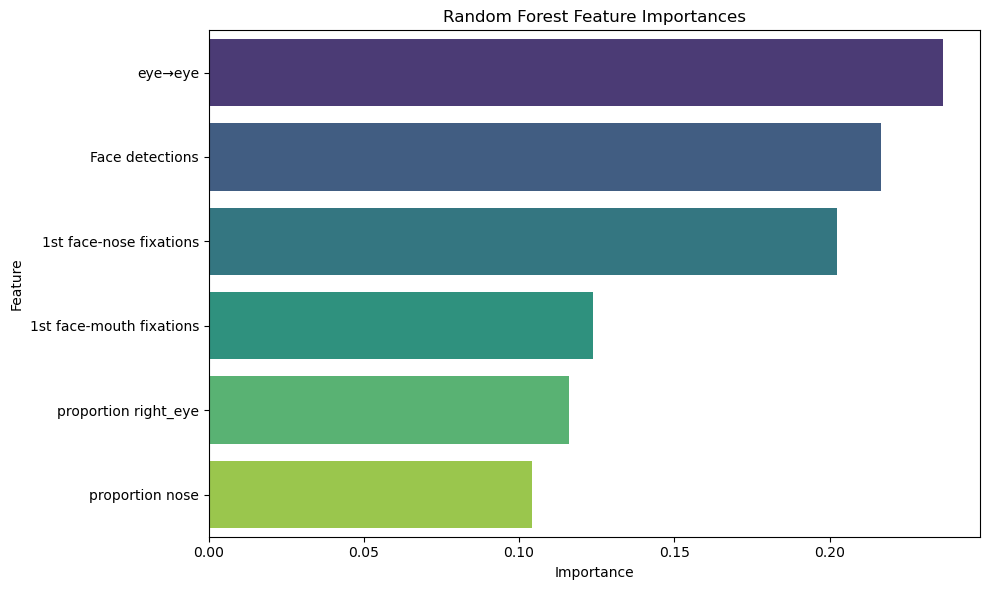

In [292]:
# Random Forest Regressor
model = RandomForestRegressor(random_state=0)
model.fit(X, y)

# Feature importances
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': predictors,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

display(feature_importance_df)

# Predict
y_pred = model.predict(X)

# R²
r2 = r2_score(y, y_pred)
print(f"R²: {r2:.3f} (Variance explained)")

# MAE and RMSE
mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f"MAE: {mae:.3f}, RMSE: {rmse:.3f}")

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df, y='Feature', x='Importance', palette='viridis')
plt.title('Random Forest Feature Importances')
plt.tight_layout()
plt.show()



In [297]:
import pandas as pd
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Assuming X and y are pandas DataFrame/Series
# X = pd.DataFrame(...) 
# y = pd.Series(...)

model = RandomForestRegressor(random_state=42)
loo = LeaveOneOut()

y_true = []
y_pred = []

for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)

    y_true.append(y_test.values[0])
    y_pred.append(y_hat[0])

import numpy as np

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print("Global RMSE:", rmse)


print("Global R²:", r2_score(y_true, y_pred))
print("Global MAE:", mean_absolute_error(y_true, y_pred))





Global RMSE: 0.010126729920860243
Global R²: -0.655654814863375
Global MAE: 0.007986256008996077


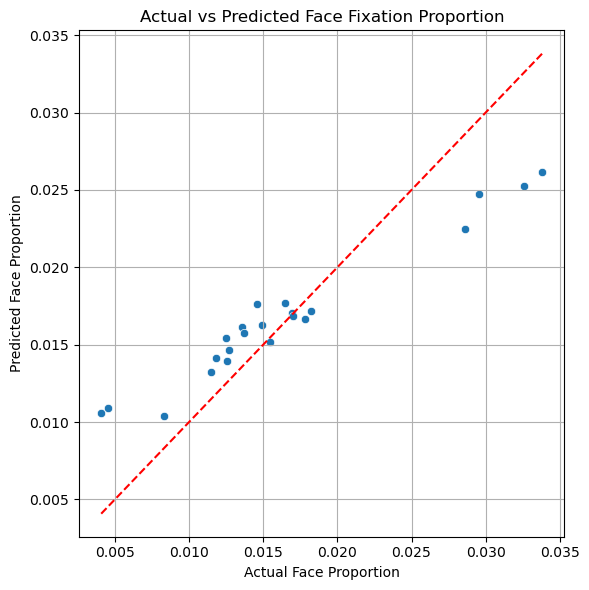

In [273]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y, y=y_pred)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # perfect prediction line
plt.xlabel("Actual Face Proportion")
plt.ylabel("Predicted Face Proportion")
plt.title("Actual vs Predicted Face Fixation Proportion")
plt.grid(True)
plt.tight_layout()
plt.show()


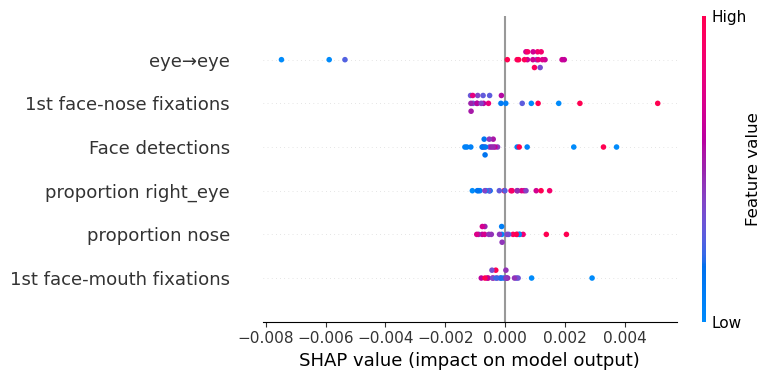

In [274]:
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

shap.summary_plot(shap_values, X)


R² (coefficient of determination) — how much variance is explained

MAE / RMSE — how far predictions are from actual values

In [275]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X, y)
print("Linear Regression R²:", model.score(X, y))


Linear Regression R²: 0.2733864886672299


In [276]:
# Assuming X and y are already defined
rf = RandomForestRegressor(random_state=0)
lr = LinearRegression()

# Cross-validation (5 folds)
rf_cv_scores = cross_val_score(rf, X, y, cv=5, scoring='r2')
lr_cv_scores = cross_val_score(lr, X, y, cv=5, scoring='r2')

# Print results
print("Random Forest CV R² Scores:", rf_cv_scores)
print("Random Forest Mean CV R²:", np.mean(rf_cv_scores))

print("\nLinear Regression CV R² Scores:", lr_cv_scores)
print("Linear Regression Mean CV R²:", np.mean(lr_cv_scores))

Random Forest CV R² Scores: [-0.085486   -0.8822382  -5.88914388 -0.83638209 -1.92224401]
Random Forest Mean CV R²: -1.923098838048253

Linear Regression CV R² Scores: [-0.14174605 -2.43440034 -4.5461887  -0.21633643 -0.42313577]
Linear Regression Mean CV R²: -1.5523614587463328


RF is fitting noise

Even if RF doesn't generalize, the feature importance rankings tell you what might matter most across participants.

Use this to:

Describe dominant attention patterns

Compare high vs low face-fixators

## Univariate Hierarchical Clustering + Silhoette score to access it

/var/folders/rl/39dttzx13m9b1_bh8gpvq64m0000gn/T/ipykernel_33937/1878319402.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


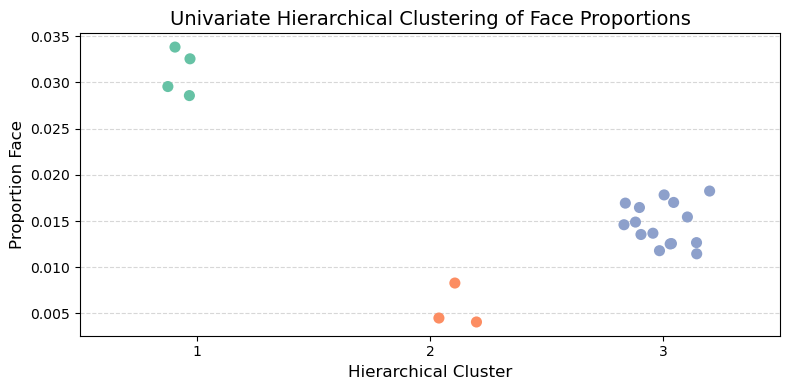

In [284]:

face_values = clustering_df[['proportion face']].values

# Perform hierarchical clustering
Z = linkage(face_values, method='ward')

# Assign cluster labels (e.g., 3 clusters)
clustering_df['face_hcluster'] = fcluster(Z, t=3, criterion='maxclust')

# Plot the strip plot
plt.figure(figsize=(8, 4))
sns.stripplot(
    data=clustering_df,
    x='face_hcluster',
    y='proportion face',
    jitter=0.2,
    palette='Set2',
    size=8
)
plt.title('Univariate Hierarchical Clustering of Face Proportions', fontsize=14)
plt.xlabel('Hierarchical Cluster', fontsize=12)
plt.ylabel('Proportion Face', fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



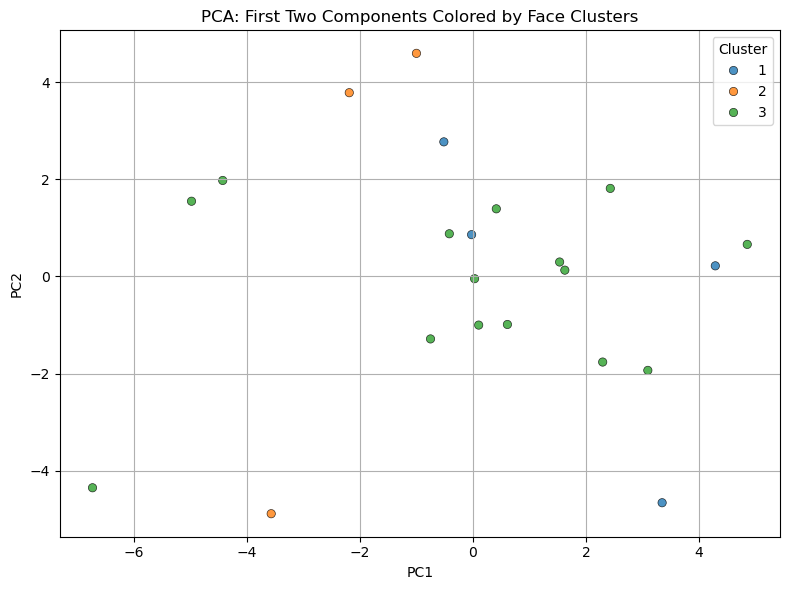

In [285]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1. Prepare features (excluding target/cluster column)
feature_cols = [col for col in all_variables_df.columns if col != 'proportion face']
X = all_variables_df[feature_cols]

# 2. Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. PCA
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# 4. Plot first 2 PCs, colored by cluster
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_pca[:, 0], 
    y=X_pca[:, 1], 
    hue=clustering_df['face_hcluster'].astype(str),  # convert to string for legend
    palette='tab10',
    edgecolor='k',
    alpha=0.8
)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA: First Two Components Colored by Face Clusters')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()


In [197]:
##Silhouette Score
#This measures how similar an object is to its own cluster compared to other clusters. A higher silhouette score means better-defined clusters.

from sklearn.metrics import silhouette_score

score = silhouette_score(face_values, clustering_df['face_hcluster'])  # data: face fixations proportion, labels: cluster assignments
print("Silhouette Score:", score)


Silhouette Score: 0.7038210840370785


In [279]:
# Group by clusters and compute means
cluster_summary = clustering_df.groupby('face_hcluster')[predictors].mean().round(3)

display(cluster_summary)

,proportion right_eye,proportion nose,eye→eye,1st face-mouth fixations,1st face-nose fixations,Face detections
face_hcluster,,,,,,
1,0.230,0.123,0.718,0.248,0.133,310321.750
2,0.083,0.123,0.083,0.428,0.177,239051.667
3,0.140,0.116,0.692,0.373,0.129,275384.867


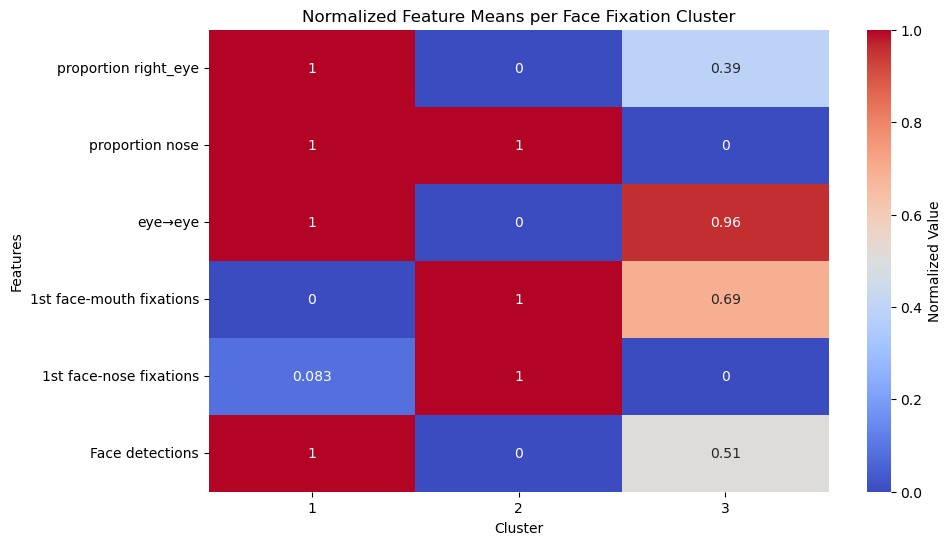

In [280]:
from sklearn.preprocessing import MinMaxScaler


# cluster_summary shape: (clusters × features)
scaler = MinMaxScaler()

# Normalize per feature (column-wise)
cluster_summary_norm = pd.DataFrame(
    scaler.fit_transform(cluster_summary),
    index=cluster_summary.index,
    columns=cluster_summary.columns
)

# normalized heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_summary_norm.T, annot=True, cmap='coolwarm', cbar_kws={'label': 'Normalized Value'})
plt.title("Normalized Feature Means per Face Fixation Cluster")
plt.xlabel("Cluster")
plt.ylabel("Features")
plt.show()




# Other

In [ ]:

# Plot the distribution
plt.figure(figsize=(8, 6))
sns.histplot(clustering_df['proportion face'], bins=30, kde=True)
plt.title('Distribution of Proportion Face')
plt.xlabel('Proportion Face')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

## Multivariate K-means (not suitable for the size of the dataset)

In [62]:
# Create the new combined eye proportion
"""clustering_df['proportion eye'] = (
    clustering_df['proportion left_eye'] + clustering_df['proportion right_eye']
)"""

target = 'proportion face'
predictors = [
    'proportion body',
    'proportion background',
    #'proportion eye',
    'proportion left_eye',
    'proportion right_eye',
    'proportion nose',
    'proportion mouth',
    'side_prop',
    'full_prop',
    'eye→eye',
    'eye→nose',
    'eye→mouth',
    'nose→eye',
    'nose→nose',
    'nose→mouth',
    'mouth→eye',
    'mouth→nose',
    'mouth→mouth',
    '1st face-eye fixations',
    '1st face-mouth fixations',
    '1st face-nose fixations',
    'Face detections'
]

X = clustering_df[predictors]
y = clustering_df[target]

/var/folders/rl/39dttzx13m9b1_bh8gpvq64m0000gn/T/ipykernel_33937/1881982764.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


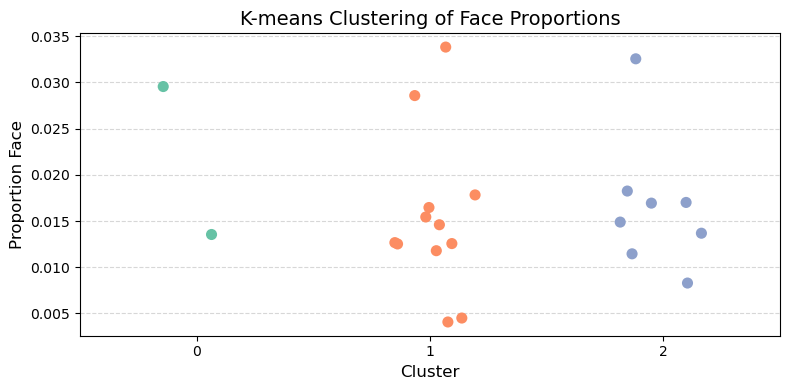

In [81]:
from sklearn.cluster import KMeans

# Fit KMeans and get cluster labels
kmeans = KMeans(n_clusters=3, random_state=42)
clustering_df['cluster'] = kmeans.fit_predict(X)

# Plot the clusters
plt.figure(figsize=(8, 4))
sns.stripplot(
    data=clustering_df,
    x='cluster',
    y='proportion face',
    jitter=0.2,
    palette='Set2',
    size=8
)
plt.title('K-means Clustering of Face Proportions', fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Proportion Face', fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [78]:
# Target: face clusters
y = clustering_df['face_cluster']

# Fit Random Forest
clf = RandomForestClassifier(random_state=42)
clf.fit(X, y)

# Cross-validate accuracy (optional but useful)
scores = cross_val_score(clf, X, y, cv=5)
print(f'Accuracy (CV mean): {scores.mean():.2f}')

# Get feature importances
importances = clf.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)



Accuracy (CV mean): 0.60
                     Feature  Importance
7                    eye→eye    0.118769
19           Face detections    0.074732
18   1st face-nose fixations    0.067470
3            proportion nose    0.067310
11                 nose→nose    0.065360
10                  nose→eye    0.059392
6                  full_prop    0.051217
0            proportion body    0.051056
8                   eye→nose    0.048185
5                  side_prop    0.043640
1        proportion left_eye    0.041464
14                mouth→nose    0.040543
17  1st face-mouth fixations    0.040388
9                  eye→mouth    0.038798
16    1st face-eye fixations    0.038031
15               mouth→mouth    0.038021
2       proportion right_eye    0.037364
13                 mouth→eye    0.037266
4           proportion mouth    0.027550
12                nose→mouth    0.013442


/Users/alina/opt/anaconda3/envs/venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


/var/folders/rl/39dttzx13m9b1_bh8gpvq64m0000gn/T/ipykernel_33937/2505462175.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Blues_d')


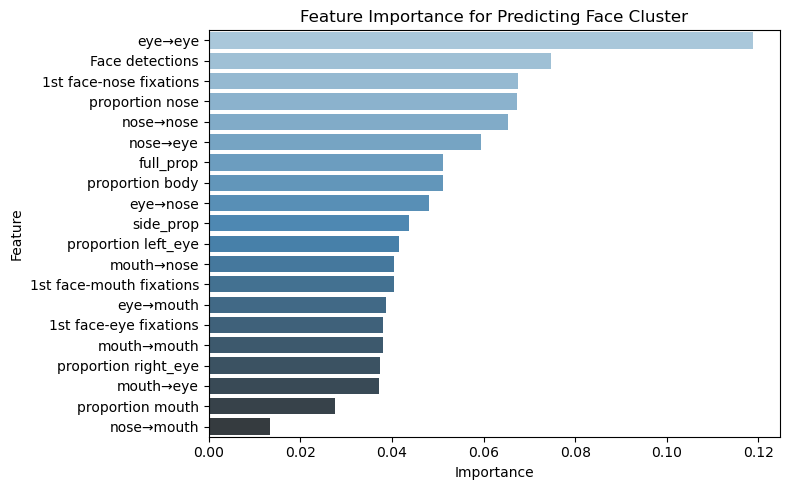

In [79]:
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Blues_d')
plt.title('Feature Importance for Predicting Face Cluster')
plt.tight_layout()
plt.show()


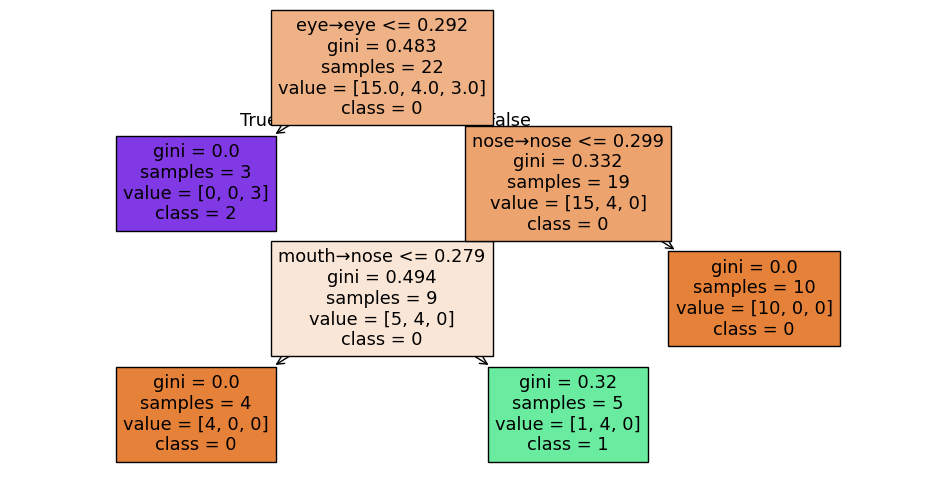

In [11]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X, y)

plt.figure(figsize=(12, 6))
plot_tree(clf, feature_names=X.columns, class_names=[str(c) for c in clf.classes_], filled=True)
plt.show()


## Multivariate Hierarchical Clustering (can be used for datasets as small as this one) - dropping the idea as my goal is understanding feature importance and not making clusters

In [115]:
# Create the new combined eye proportion
"""clustering_df['proportion eye'] = (
    clustering_df['proportion left_eye'] + clustering_df['proportion right_eye']
)"""

target = 'proportion face'
predictors = [
    'proportion body',
    #'proportion background',
    #'proportion eye',
    'proportion left_eye',
    'proportion right_eye',
    'proportion nose',
    'proportion mouth',
    'side_prop',
    'full_prop',
    'eye→eye',
    'eye→nose',
    'eye→mouth',
    'nose→eye',
    'nose→nose',
    'nose→mouth',
    'mouth→eye',
    'mouth→nose',
    'mouth→mouth',
    '1st face-eye fixations',
    '1st face-mouth fixations',
    '1st face-nose fixations',
    'Face detections'
]

X = clustering_df[predictors]
y = clustering_df[target]

In [116]:
correlations = clustering_df[predictors + [target]].corr()[target].drop(target)
print(correlations.sort_values(ascending=False))

mouth→eye                   0.408042
proportion right_eye        0.401541
eye→eye                     0.393182
nose→eye                    0.364976
1st face-eye fixations      0.272209
Face detections             0.205847
proportion left_eye         0.197264
proportion body             0.072162
full_prop                   0.042128
proportion nose             0.027425
nose→nose                  -0.033191
side_prop                  -0.042128
mouth→nose                 -0.078604
1st face-nose fixations    -0.094443
nose→mouth                 -0.130640
proportion mouth           -0.146819
eye→nose                   -0.174778
eye→mouth                  -0.184193
1st face-mouth fixations   -0.247202
mouth→mouth                -0.254010
Name: proportion face, dtype: float64


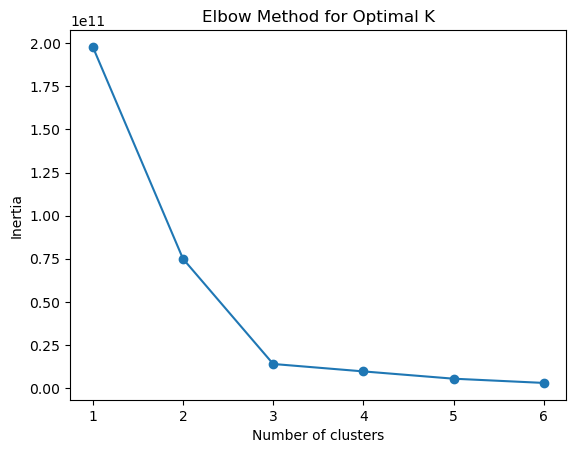

In [117]:
## Look for the "elbow" point — the number of clusters where the line starts flattening (3)
inertias = []
K_range = range(1, 7)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X)
    inertias.append(km.inertia_)

plt.plot(K_range, inertias, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(K_range)
plt.show()

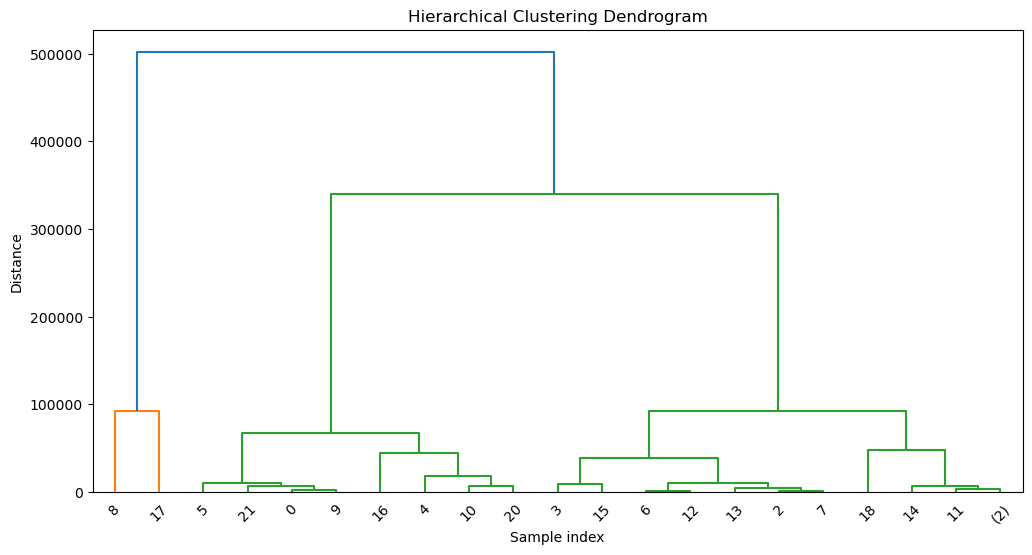

In [107]:
from sklearn.preprocessing import StandardScaler #used to standardize features — i.e., make them have zero mean and unit variance
from scipy.cluster.hierarchy import linkage, dendrogram # computes the hierarchical clustering tree (a linkage matrix) and dendrogram creates a visual representation

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Compute linkage matrix
Z = linkage(X, method='ward')  # 'ward' method minimizes variance within clusters 

# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='level', p=5)  # showing last 5 cluster merges
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample index")
plt.ylabel("Distance")
plt.show()



/var/folders/rl/39dttzx13m9b1_bh8gpvq64m0000gn/T/ipykernel_33937/1022892403.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


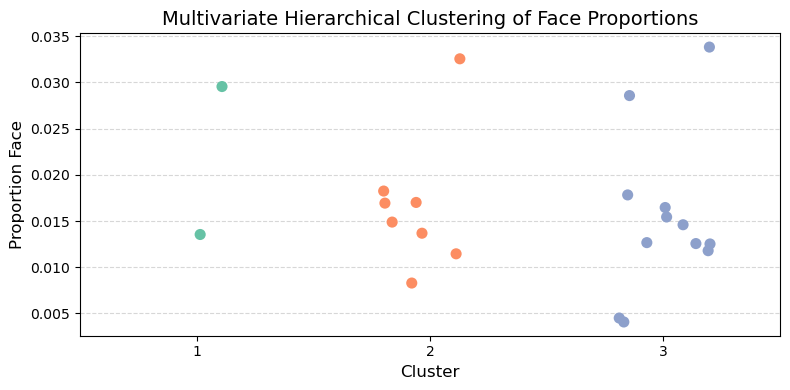

In [108]:
from scipy.cluster.hierarchy import fcluster

# Assign cluster labels (e.g., into 3 clusters)
cluster_labels = fcluster(Z, t=3, criterion='maxclust')

clustering_df['cluster'] = cluster_labels

# Assign cluster labels (e.g., into 3 clusters)
cluster_labels = fcluster(Z, t=3, criterion='maxclust')

# Plot the clusters
plt.figure(figsize=(8, 4))
sns.stripplot(
    data=clustering_df,
    x='cluster',
    y='proportion face',
    jitter=0.2,
    palette='Set2',
    size=8
)
plt.title('Multivariate Hierarchical Clustering of Face Proportions', fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Proportion Face', fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [119]:
cluster_means = clustering_df.groupby('cluster')[predictors].mean() #'face_hcluster'
print(cluster_means)


               proportion body  proportion left_eye  proportion right_eye  \
face_hcluster                                                               
1                     0.319465             0.195496              0.230131   
2                     0.301093             0.074693              0.082790   
3                     0.336896             0.196591              0.139841   

               proportion nose  proportion mouth  side_prop  full_prop  \
face_hcluster                                                            
1                     0.122516          0.139507   0.142483   0.857517   
2                     0.122579          0.193627   0.169401   0.830599   
3                     0.115889          0.212815   0.140135   0.859865   

                eye→eye  eye→nose  eye→mouth  nose→eye  nose→nose  nose→mouth  \
face_hcluster                                                                   
1              0.718236  0.160849   0.120915  0.600152   0.233012    0.166836   


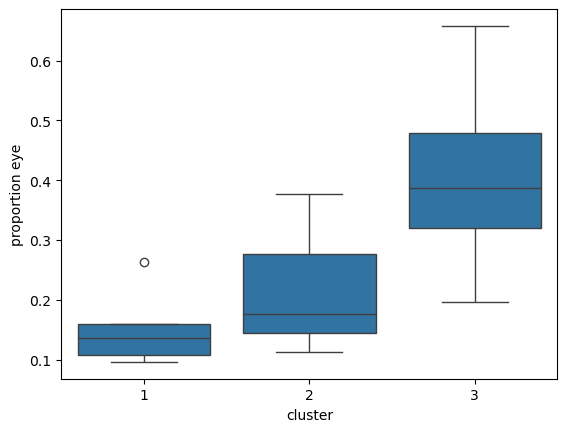

In [34]:
sns.boxplot(data=clustering_df, x='cluster', y='proportion eye')
plt.show()


Train a classifier (e.g., Random Forest) to predict the cluster labels using your features.

Then extract feature importances from that model.

This approach treats the cluster labels as “pseudo-labels” and shows which features best separate the clusters.

In [120]:
from sklearn.ensemble import RandomForestClassifier

X = clustering_df[predictors]
y = clustering_df['face_hcluster']

rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': predictors,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(feature_importance_df)


                     feature  importance
7                    eye→eye    0.118769
19           Face detections    0.074732
18   1st face-nose fixations    0.067470
3            proportion nose    0.067310
11                 nose→nose    0.065360
10                  nose→eye    0.059392
6                  full_prop    0.051217
0            proportion body    0.051056
8                   eye→nose    0.048185
5                  side_prop    0.043640
1        proportion left_eye    0.041464
14                mouth→nose    0.040543
17  1st face-mouth fixations    0.040388
9                  eye→mouth    0.038798
16    1st face-eye fixations    0.038031
15               mouth→mouth    0.038021
2       proportion right_eye    0.037364
13                 mouth→eye    0.037266
4           proportion mouth    0.027550
12                nose→mouth    0.013442


/Users/alina/opt/anaconda3/envs/venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


CV Accuracy: 0.600 ± 0.138
                     feature  importance
7                    eye→eye    0.118769
19           Face detections    0.074732
18   1st face-nose fixations    0.067470
3            proportion nose    0.067310
11                 nose→nose    0.065360
10                  nose→eye    0.059392
6                  full_prop    0.051217
0            proportion body    0.051056
8                   eye→nose    0.048185
5                  side_prop    0.043640
1        proportion left_eye    0.041464
14                mouth→nose    0.040543
17  1st face-mouth fixations    0.040388
9                  eye→mouth    0.038798
16    1st face-eye fixations    0.038031
15               mouth→mouth    0.038021
2       proportion right_eye    0.037364
13                 mouth→eye    0.037266
4           proportion mouth    0.027550
12                nose→mouth    0.013442


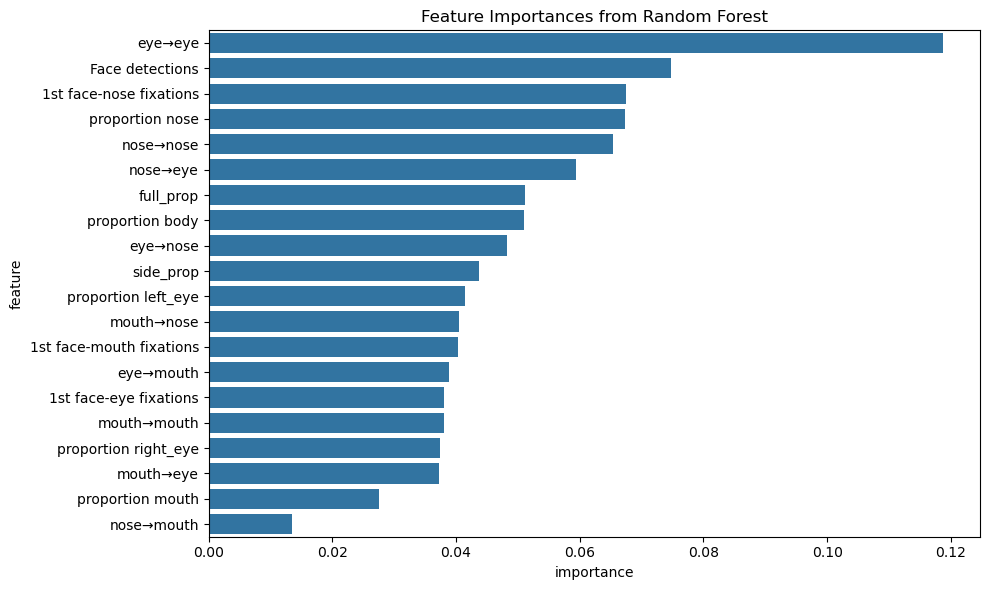

In [121]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


X = clustering_df[predictors]
y = clustering_df['face_hcluster'].astype(int)  # make sure target is int for classification

# Train Random Forest
rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(X, y)

# Cross-validation accuracy
scores = cross_val_score(rf, X, y, cv=5)
print(f'CV Accuracy: {scores.mean():.3f} ± {scores.std():.3f}')

# Feature importances
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': predictors,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(feature_importance_df)

# Optional: plot feature importances
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importances from Random Forest')
plt.tight_layout()
plt.show()


Shows how well your cluster labels can be predicted by the features.

Gives a ranked list of features contributing most to cluster separation.

Helps understand which behaviors or proportions matter most for differentiating clusters.

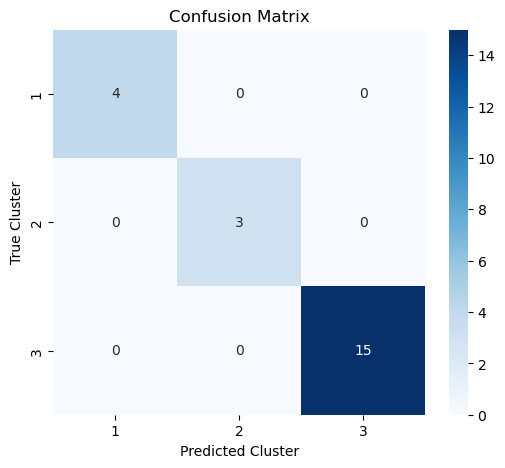

              precision    recall  f1-score   support

   Cluster 1       1.00      1.00      1.00         4
   Cluster 2       1.00      1.00      1.00         3
   Cluster 3       1.00      1.00      1.00        15

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22



In [123]:
from sklearn.metrics import confusion_matrix, classification_report

unique_clusters = sorted(clustering_df['face_hcluster'].unique())

# Predict cluster labels using the trained Random Forest
y_pred = rf.predict(X)

# Confusion matrix
cm = confusion_matrix(y, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_clusters, yticklabels=unique_clusters)
plt.xlabel('Predicted Cluster')
plt.ylabel('True Cluster')
plt.title('Confusion Matrix')
plt.show()

# Classification report
report = classification_report(y, y_pred, target_names=[f'Cluster {c}' for c in unique_clusters])
print(report)



Feature importances for Cluster 2 vs Rest:
                 feature  importance
19       Face detections    0.225677
0        proportion body    0.115806
2   proportion right_eye    0.055202
4       proportion mouth    0.052497
6              full_prop    0.052160
13             mouth→eye    0.051538
7                eye→eye    0.049793
10              nose→eye    0.046736
5              side_prop    0.045460
9              eye→mouth    0.038192


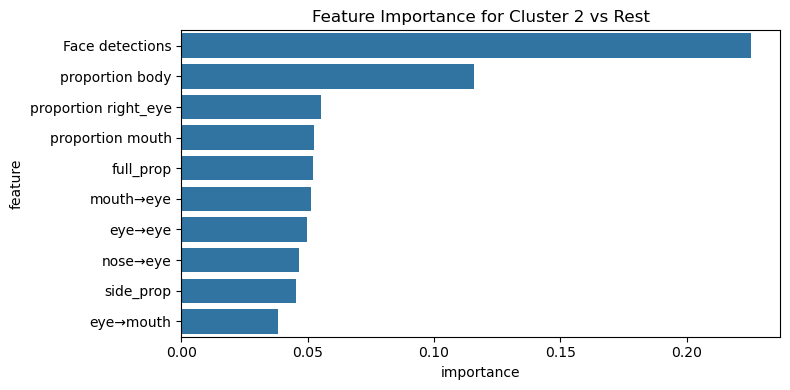


Feature importances for Cluster 3 vs Rest:
                 feature  importance
19       Face detections    0.344758
0        proportion body    0.176407
13             mouth→eye    0.082168
2   proportion right_eye    0.034009
5              side_prop    0.033307
8               eye→nose    0.033221
6              full_prop    0.031325
12            nose→mouth    0.030275
1    proportion left_eye    0.028043
10              nose→eye    0.027705


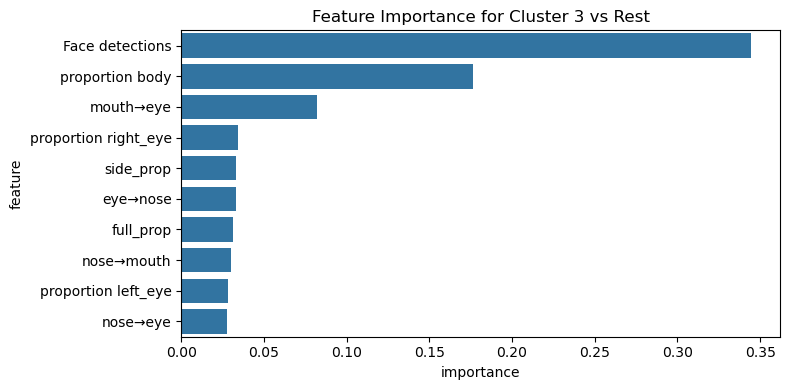


Feature importances for Cluster 1 vs Rest:
             feature  importance
19   Face detections    0.268618
7            eye→eye    0.130947
10          nose→eye    0.071947
15       mouth→mouth    0.059129
13         mouth→eye    0.048728
4   proportion mouth    0.046966
5          side_prop    0.042870
3    proportion nose    0.041495
8           eye→nose    0.040940
6          full_prop    0.035875


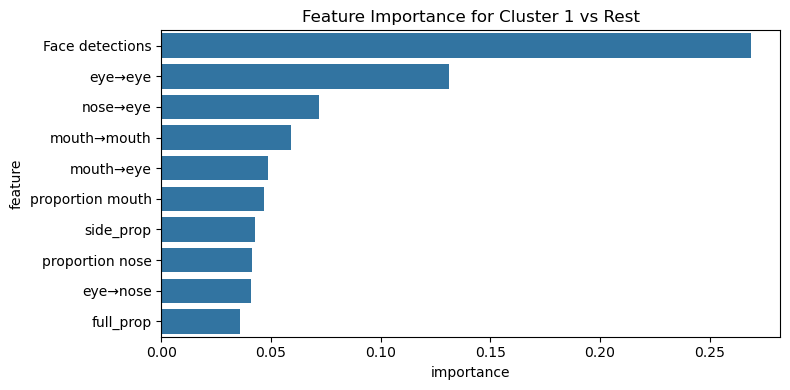

In [71]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

X = clustering_df[predictors]
y = clustering_df['cluster'].astype(int)

unique_clusters = y.unique()

for cluster in unique_clusters:
    print(f"\nFeature importances for Cluster {cluster} vs Rest:")
    
    # Create binary target: 1 if current cluster, else 0
    y_binary = (y == cluster).astype(int)
    
    rf = RandomForestClassifier(random_state=42, n_estimators=100)
    rf.fit(X, y_binary)
    
    importances = rf.feature_importances_
    fi_df = pd.DataFrame({'feature': predictors, 'importance': importances}).sort_values(by='importance', ascending=False)
    
    print(fi_df.head(10))  # top 10 features
    
    # Optional: plot
    plt.figure(figsize=(8, 4))
    sns.barplot(x='importance', y='feature', data=fi_df.head(10))
    plt.title(f'Feature Importance for Cluster {cluster} vs Rest')
    plt.tight_layout()
    plt.show()
